In [5]:
# Define SI unit prefixes
nm = nHz = nA = nV = nW = 1e-9
um = uHz = uA = uV = uW = 1e-6
mm = mHz = mA = mV = mW = 1e-3
cm = 1e2
Hz = A = V = W = 1
kHz = kA = kV = kW = 1e3
MHz = MA = MV = MW = 1e6
GHz = GA = GV = GW = 1e9

Okay this is going to be a rough attempt at extracting fit values from imaged clouds. We will pull the data straight out of the Artiq dataset so expect some wrangling to get it looking nice

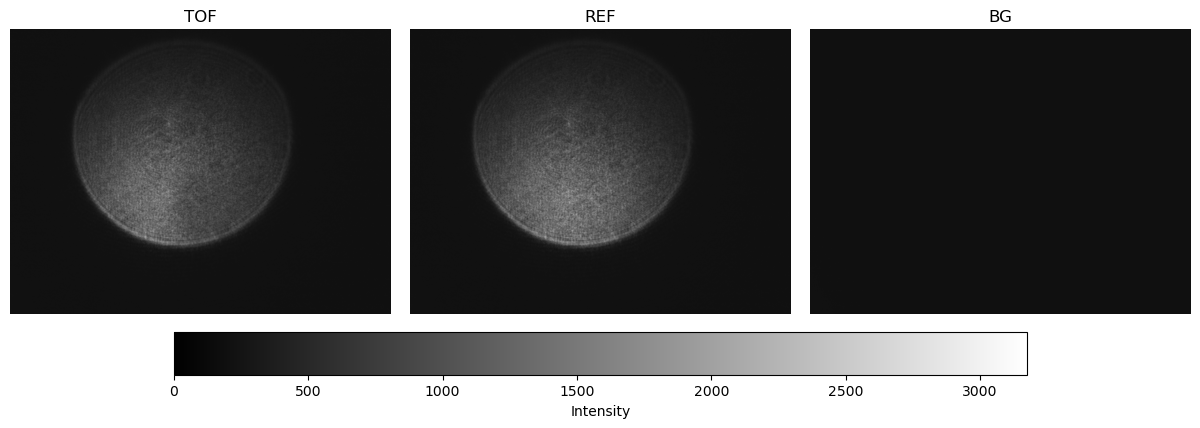

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from artiq.frontend.artiq_master import DatasetDB

db = DatasetDB("/home/ae19663/artiq/dataset_db.mdb")
temp = {k: v[1] for k, v in db.data.raw_view.items()}
def rot_and_flip(arr):
    return np.rot90(np.flip(arr, 1))

imgs = {
    "TOF": rot_and_flip(db.data.raw_view["Images.absorption.TOF"][1]),
    "REF": rot_and_flip(db.data.raw_view["Images.absorption.REF"][1]),
    "BG": rot_and_flip(db.data.raw_view["Images.absorption.BG"][1]),
}

# plot the three images in a 1x3 grid
absmax = max([img.max() for img in imgs.values()])
absmin = min([img.min() for img in imgs.values()])

fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# Plot each image
for i, (name, img) in enumerate(imgs.items()):
    im = axs[i].imshow(img, cmap="gray", vmin=absmin, vmax=absmax)
    axs[i].set_title(name)
    axs[i].axis("off")

# Add a single colorbar on the bottom
cbar = fig.colorbar(im, ax=axs, location="bottom", orientation="horizontal", shrink=0.8)
cbar.set_label("Intensity")

plt.show()

In [7]:
from scipy.ndimage import gaussian_filter
import logging
import numpy as np
from lmfit import Model
import functools


def gaussian_2D(x, y, A, x0, y0, sx, sy, theta=0, z0=0):
    """Takes a meshgrid of x, y and returns the gaussian computed across all values.
    See https://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function
    """
    cos_sq = np.square(np.cos(theta))
    sin_sq = np.square(np.sin(theta))
    sin2th = np.sin(2 * theta)
    sx_sq = np.square(sx)
    sy_sq = np.square(sy)

    # General 2D Gaussian equation parameters
    a = cos_sq / (2 * sx_sq) + sin_sq / (2 * sy_sq)
    b = sin2th / (4 * sy_sq) - sin2th / (4 * sx_sq)
    c = sin_sq / (2 * sx_sq) + cos_sq / (2 * sy_sq)

    quadratic = (
        a * np.square(x - x0) + 2 * b * (x - x0) * (y - y0) + c * np.square(y - y0)
    )
    return A * np.exp(-quadratic) + z0


def ravel(func):
    """Decorator that ravels the return value of the decorated function."""

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        return np.ravel(func(*args, **kwargs))

    return wrapper


class AbsImage:
    def __init__(self, data, ref, bg):
        assert(data.shape == ref.shape == bg.shape)
        self.data_image = data
        self.ref_image = ref
        self.bg_image = bg

        self.height = data.shape[0]
        self.width = data.shape[1]

        self.wavelength = 780.24 * nm
        self.detuning = 0 * MHz
        self.linewidth = 6.065 * MHz
        self.pixel_size = 6.45 * um
        self.magnification = 0.3333

    @property
    def physical_scale(self):
        """Pixel to real-space size in m."""
        scale = self.pixel_size * (1 / self.magnification)
        print(f"we expect about 33mm/200pixels = 0.165mm/pixel but get {scale*1e3}mm/pixel")
        return scale

    @property
    def optical_density(self):
        smoothed_transmission = gaussian_filter(self.transmission, sigma=1)
        od = -np.log(smoothed_transmission, where=smoothed_transmission > 0)
        return od

    @property
    def transmission(self):
        """Returns the beam and dark-field compensated transmission image. Dark-field is subtracted
        from both the atom image and the beam image, and the atom image is divided by the beam
        image, giving the transmission t^2. The values should optimally lie in the range of [0, 1]
        but can realistically be in the range of [-0.1, 1.5] due to noise and beam variation across
        images."""
        logging.info("Performing background subtraction")
        atoms = np.subtract(self.data_image, self.bg_image)
        light = np.subtract(self.ref_image, self.bg_image)

        # If the light data is below some threshold, we assume that any
        # atom data at this location is invalid and treat as if no transmission.
        # The threshold value was selected experimentally
        threshold = 100
        transmission = np.divide(atoms, light, where=light > threshold)
        transmission[light <= threshold] = 1
        np.clip(transmission, a_min=0, a_max=1, out=transmission)

        return transmission

    @property
    def absorption(self):
        """Raw absorption data"""
        return 1 - self.transmission

    @property
    def atom_number(self):
        """Calculates the total atom number from the transmission ROI values."""
        # light and camera parameters
        sigma_0 = (3 / (2 * np.pi)) * np.square(self.wavelength)  # cross-section
        sigma = sigma_0 * np.reciprocal(
            1 + np.square(self.detuning / (self.linewidth / 2))
        )  # off resonance
        area = np.square(self.physical_scale)  # pixel area in SI units

        optical_density = self.optical_density[self.sigma_mask]

        return (
            (area / sigma) * np.sum(optical_density) / 0.866
        )  # Divide by 1.5-sigma area

    @property
    def peak(self):
        """Returns x, y, z of brightest pixel in absorption"""
        y, x = np.unravel_index(
            np.argmax(self.optical_density), self.optical_density.shape
        )
        z = self.optical_density[y, x]

        logging.info("Finding transmission peak - x: %i, y: %i, z: %i", x, y, z)
        return x, y, z

    @property
    def centroid(self):
        """Returns x, y of the centroid of the absorption image"""
        y, x = np.mgrid[0 : self.height, 0 : self.width]
        A = np.sum(self.optical_density)
        x_c = np.sum(x * self.optical_density) / A
        y_c = np.sum(y * self.optical_density) / A
        return x_c, y_c

    @property
    def sigma_mask(self):
        """Returns a numpy mask of pixels within the 2-sigma limit of the model (no ROI)"""
        bp_2D = self.best_values
        x0, y0, a, b, theta = (bp_2D[k] for k in ("x0", "y0", "sx", "sy", "theta"))
        y, x = np.ogrid[0 : self.height, 0 : self.width]

        # https://math.stackexchange.com/a/434482
        maj_axis = np.square((x - x0) * np.cos(theta) - (y - y0) * np.sin(theta))
        min_axis = np.square((x - x0) * np.sin(theta) + (y - y0) * np.cos(theta))
        bound = 4.343 # chi2.ppf(0.886, df=2)

        array = np.zeros(self.data_image.shape, dtype="bool")
        array[maj_axis / np.square(a) + min_axis / np.square(b) <= bound] = True
        return array

    @functools.cached_property
    def fit(self):
        """Fits a 2D Gaussian against the absorption."""
        logging.info("Running 2D fit...")

        x_mg, y_mg = np.mgrid[0 : self.height, 0 : self.width]
        model = Model(ravel(gaussian_2D), independent_vars=["x", "y"])

        x_s, y_s, vary_center = 100, 100, True
        x_c, y_c, A = self.peak

        model.set_param_hint("A", value=A, min=0, max=6)
        model.set_param_hint(
            "x0", value=x_c, min=0, max=self.width, vary=vary_center
        )
        model.set_param_hint(
            "y0", value=y_c, min=0, max=self.height, vary=vary_center
        )

        model.set_param_hint("sx", min=1, max=self.width)
        model.set_param_hint("sy", min=1, max=self.height)
        model.set_param_hint(
            "theta", min=-np.pi / 4, max=np.pi / 4, vary=False
        )
        model.set_param_hint("z0", min=-1, max=1, vary=False)

        result = model.fit(
            np.ravel(self.optical_density[::5]),
            x=x_mg[::5],
            y=y_mg[::5],
            sx=x_s,
            sy=y_s,
            theta=0,
            z0=0,
            max_nfev=100,
            # scale_covar=False,
            fit_kws={"xtol": 1e-7},
        )
        logging.info(result.fit_report())

        if abs(result.summary()['rsquared']) < 0.9:
            logging.error(f"Fit did not converge:\n{result.fit_report()}")
        return result

    @property
    def best_values(self):
        return self.fit.best_values

    def eval(self, *, x, y):
        """Evaluates the fit at the given coordinates (proxy for ModelResult)."""
        return self.fit.eval(x=x, y=y)

we expect about 33mm/200pixels = 0.165mm/pixel but get 0.019351935193519354mm/pixel


ERROR:root:Fit did not converge:
[[Model]]
    Model(gaussian_2D)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 289536
    # variables        = 5
    chi-square         = 205.010911
    reduced chi-square = 7.0808e-04
    Akaike info crit   = -2099986.42
    Bayesian info crit = -2099933.54
    R-squared          = 0.85668109
[[Variables]]
    A:      0.47285208 +/- 4.6984e-04 (0.10%) (init = 0.5510594)
    x0:     650.345964 +/- 0.09727725 (0.01%) (init = 690)
    y0:     726.521604 +/- 0.10362265 (0.01%) (init = 666)
    sx:     97.9020549 +/- 0.09727757 (0.10%) (init = 100)
    sy:     104.287789 +/- 0.10362263 (0.10%) (init = 100)
    theta:  0 (fixed)
    z0:     0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, sy) = -0.5000
    C(A, sx) = -0.5000


we have 3.16e+07 atoms


'\nTOF:\n\nfit x: np.square(self.independent_var + config.repump_time)\nfit y: np.square(self.sigma_x) and np.square(self.sigma_y)\n\ntemp = slope * shot.atom_mass / KB\n\nuse centroids instead of fitted locations for nicer results when held?\n\n'

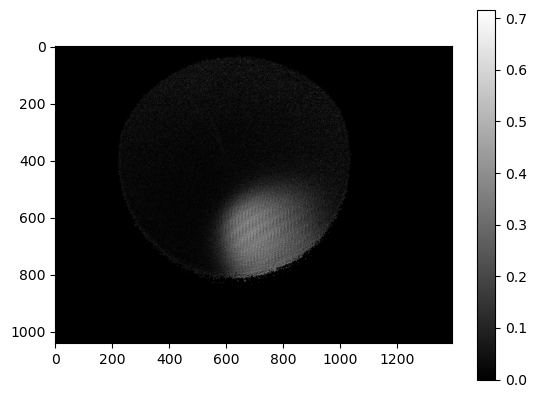

In [8]:


shot = AbsImage(
    data=imgs["TOF"],
    ref=imgs["REF"],
    bg=imgs["BG"]
)
plt.imshow(shot.absorption, cmap="gray")
plt.colorbar()
# print(shot.fit.fit_report())
print(f"we have {shot.atom_number:.2e} atoms")

"""
TOF:

fit x: np.square(self.independent_var + config.repump_time)
fit y: np.square(self.sigma_x) and np.square(self.sigma_y)

temp = slope * shot.atom_mass / KB

use centroids instead of fitted locations for nicer results when held?

"""